In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.metrics import Metrics
from arch import arch_model
from functools import reduce

sns.set_theme(font_scale=1.5, style="whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]

%load_ext autoreload
%autoreload 2

# Load data

In [4]:
returns_BTC = pd.read_csv('../data/BTC_returns.csv', index_col=0, parse_dates=True).squeeze(); returns_BTC.name = 'BTC'
returns_ETH = pd.read_csv('../data/ETH_returns.csv', index_col=0, parse_dates=True).squeeze(); returns_ETH.name = 'ETH'
returns_industry = pd.read_csv('../data/industry_returns.csv', index_col=0, parse_dates=True) / 100

returns = pd.concat([returns_BTC, returns_ETH, returns_industry], axis=1).loc['2017-01-01':]
returns = returns.drop(columns=['Other'])

n_assets = returns.shape[1]

In [5]:
eq_weight = np.array([0.05, 0.05] + [0.9 / 4] * 4)
weights = pd.DataFrame(np.tile(eq_weight, (len(returns), 1)), index=returns.index, columns=returns.columns)

portfolio_returns = (returns.fillna(0) @ eq_weight)

In [6]:
def garch_vola(returns):
    am = arch_model(returns * 100, p=1, q=1, vol='Garch', dist='normal').fit(disp='off')
    return (am.forecast(horizon=1).variance ** 0.5 / 100).values[0][0]


# Estimate volatilites

In [7]:
volas_garch = pd.Series(index=portfolio_returns.index)

for t in tqdm(portfolio_returns.index[250:]):
    volas_garch.loc[t] = garch_vola(portfolio_returns.loc[:t].iloc[-250:])
volas_garch *= np.sqrt(250)

100%|██████████| 2565/2565 [00:26<00:00, 96.82it/s] 


In [8]:
halflife = 10
sigma_tar = 0.1

volas_ewma = portfolio_returns.ewm(halflife=halflife).std() * np.sqrt(250)
volas_mad = portfolio_returns.abs().ewm(halflife=halflife).mean() * np.sqrt(np.pi/2) * np.sqrt(250)
volas_median = portfolio_returns.abs().rolling(10).median() * np.sqrt(np.pi/2) * np.sqrt(250) / 0.6745

times = reduce(np.intersect1d, [volas_ewma.dropna().index, volas_mad.dropna().index, volas_garch.dropna().index])

thetas_ewma = np.minimum(1, sigma_tar / volas_ewma)
thetas_mad = np.minimum(1, sigma_tar / volas_mad)
thetas_median = np.minimum(1, sigma_tar / volas_median)
thetas_garch = np.minimum(1, sigma_tar / volas_garch)

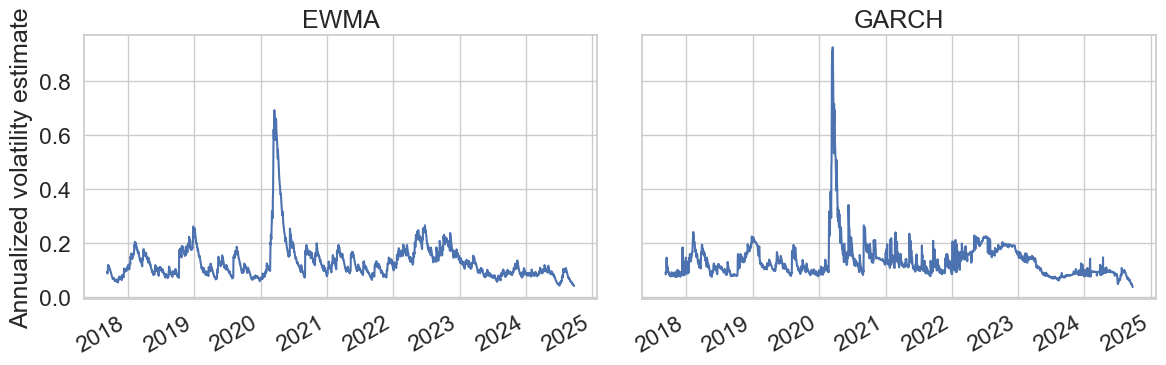

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

volas_ewma.loc[times].plot(ax=axes[0], label='EWMA')
axes[0].set_title('EWMA')
volas_garch.loc[times].plot(ax=axes[1], label='GARCH')
axes[1].set_title('GARCH')

axes[0].set_ylabel('Annualized volatility estimate')
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/volas.png')
plt.show()

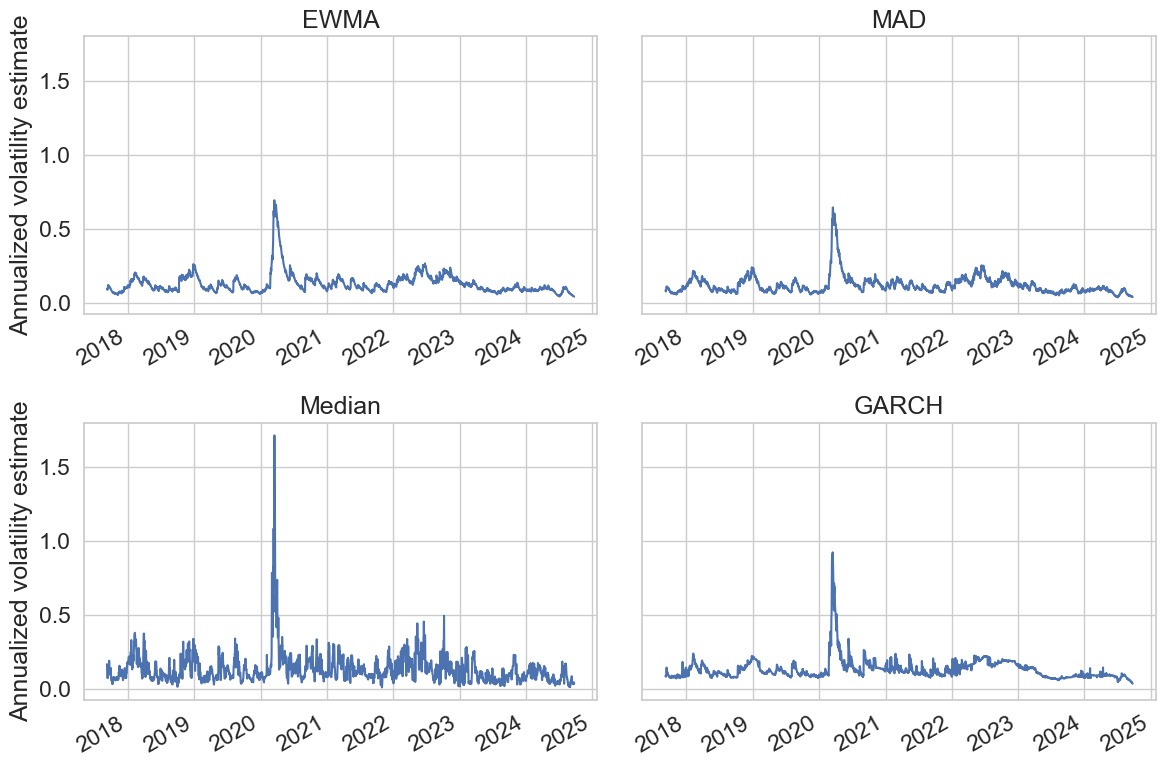

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

volas_ewma.loc[times].plot(ax=axes[0, 0], label='EWMA')
axes[0, 0].set_title('EWMA')
volas_mad.loc[times].plot(ax=axes[0, 1], label='MAD')
axes[0, 1].set_title('MAD')
volas_median.loc[times].plot(ax=axes[1, 0], label='Median')
axes[1, 0].set_title('Median')
volas_garch.loc[times].plot(ax=axes[1, 1], label='GARCH')
axes[1, 1].set_title('GARCH')

axes[0,0].set_ylabel('Annualized volatility estimate')
axes[1,0].set_ylabel('Annualized volatility estimate')
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/volas.png')
plt.show()


In [11]:
weights_ewma = weights * thetas_ewma.values[:, None]
weights_mad = weights * thetas_mad.values[:, None]
weights_median = weights * thetas_median.values[:, None]
weights_garch = weights * thetas_garch.values[:, None]

metrics_ewma = Metrics(weights_ewma.loc[times], 1-weights_ewma.loc[times].sum(axis=1), returns.loc[times].shift(-1))
metrics_mad = Metrics(weights_mad.loc[times], 1-weights_mad.loc[times].sum(axis=1), returns.loc[times].shift(-1))
metrics_median = Metrics(weights_median.loc[times], 1-weights_median.loc[times].sum(axis=1), returns.loc[times].shift(-1))
metrics_garch = Metrics(weights_garch.loc[times], 1-weights_garch.loc[times].sum(axis=1), returns.loc[times].shift(-1))

summary_df = pd.concat([metrics_ewma.summary, metrics_mad.summary, metrics_median.summary, metrics_garch.summary], axis=1)
summary_df.columns = ['EWMA', 'MAD', 'Median', 'GARCH']
summary_df.round(3)

,EWMA,MAD,Median,GARCH
Mean return,0.104,0.107,0.099,0.100
Volatility,0.098,0.104,0.099,0.097
Sharpe ratio,1.057,1.025,0.997,1.036
Max drawdown,0.199,0.212,0.212,0.197


# Portfolio weights

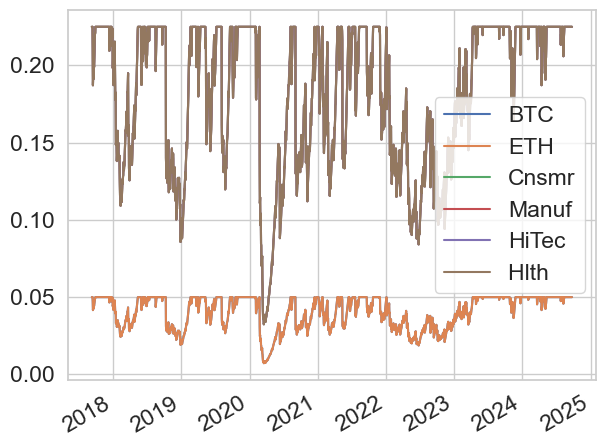

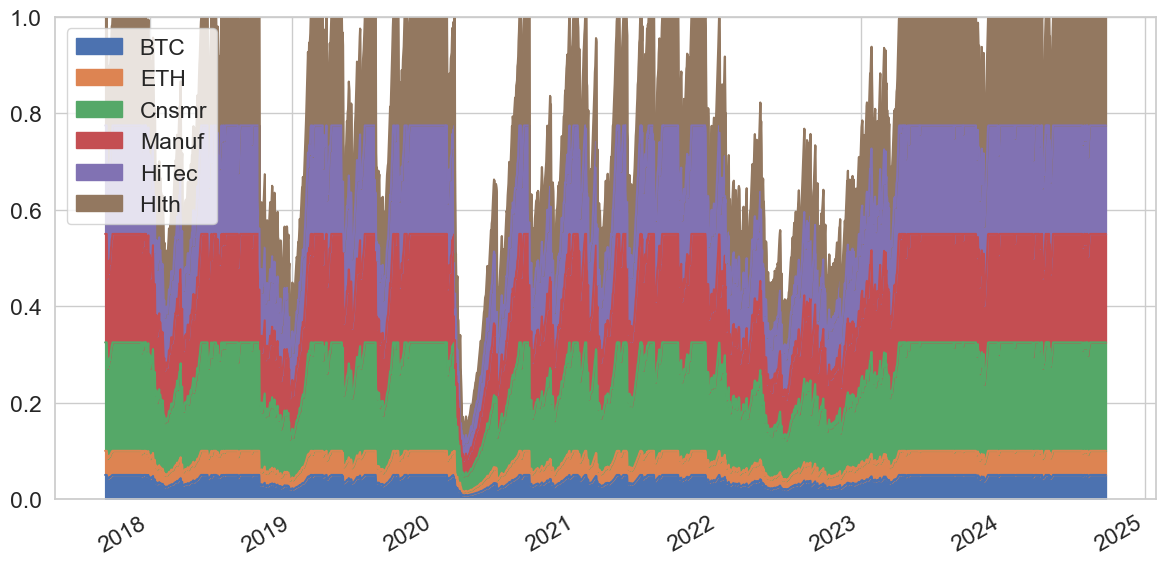

In [12]:
weights_ = weights_ewma.loc[times]
weights_.plot()
plt.gcf().autofmt_xdate()
plt.tight_layout()


fig, ax = plt.subplots(figsize=(12, 6))
weights_.plot(kind='area', stacked=True, ax=ax, color=colors)

# ax.stackplot(weights_.index, weights_.T, labels=weights_.columns)
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/weights_ewma.png')
plt.show()

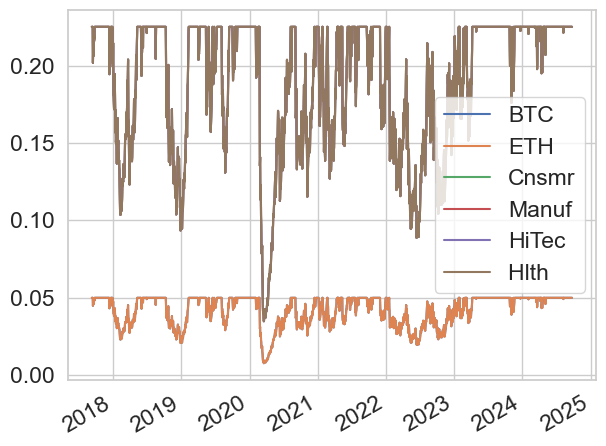

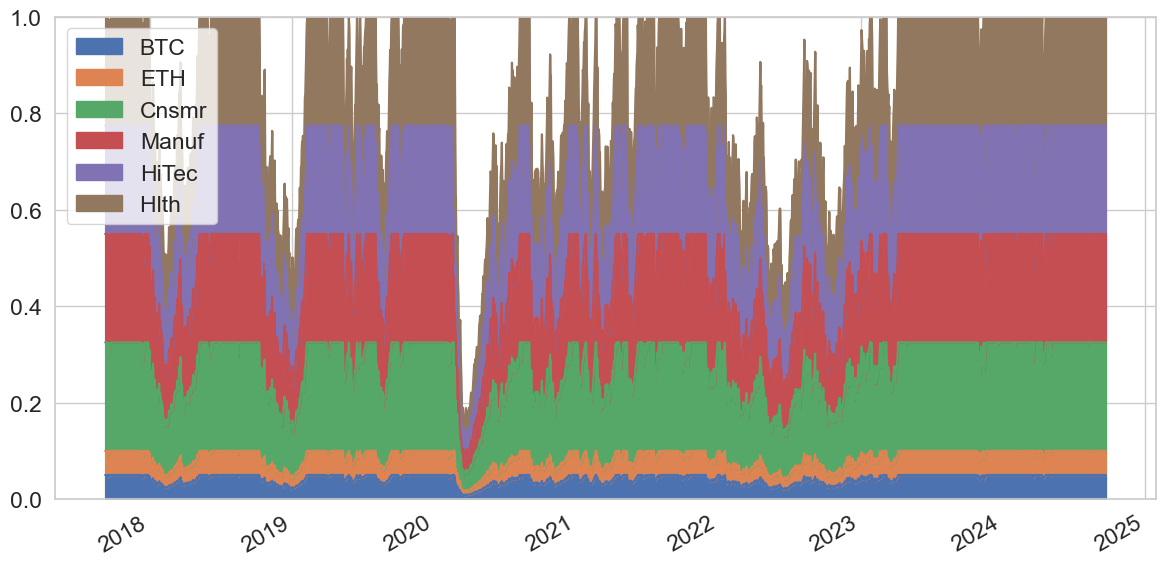

In [13]:
weights_ = weights_mad.loc[times]
weights_.plot()
plt.gcf().autofmt_xdate()
plt.tight_layout()


fig, ax = plt.subplots(figsize=(12, 6))
weights_.plot(kind='area', stacked=True, ax=ax, color=colors)
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/weights_mad.png')
plt.show()

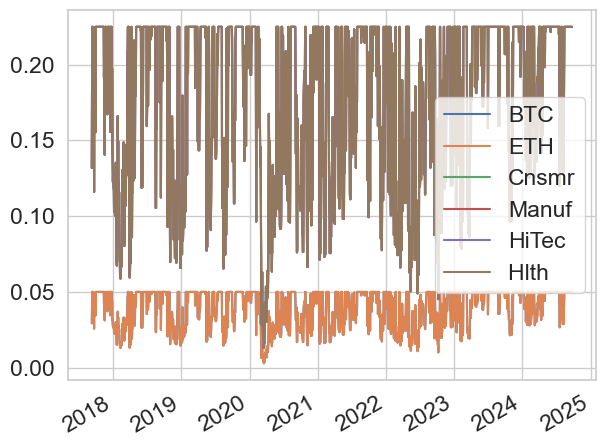

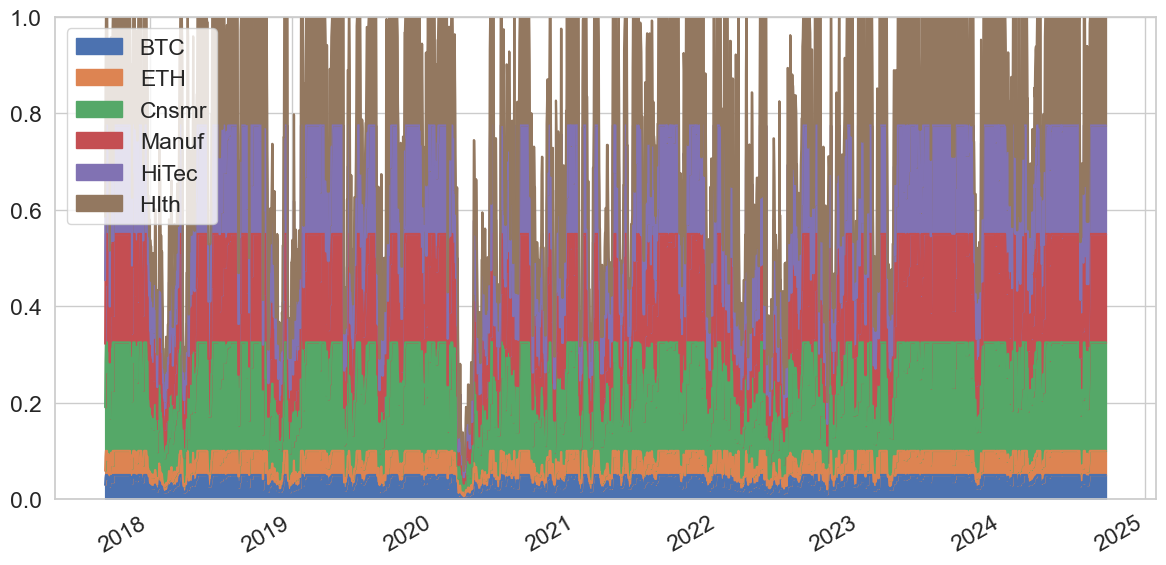

In [14]:
weights_ = weights_median.loc[times]
weights_.plot()
plt.gcf().autofmt_xdate()
plt.tight_layout()


fig, ax = plt.subplots(figsize=(12, 6))
weights_.plot(kind='area', stacked=True, ax=ax, color=colors)
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/weights_median.png')
plt.show()

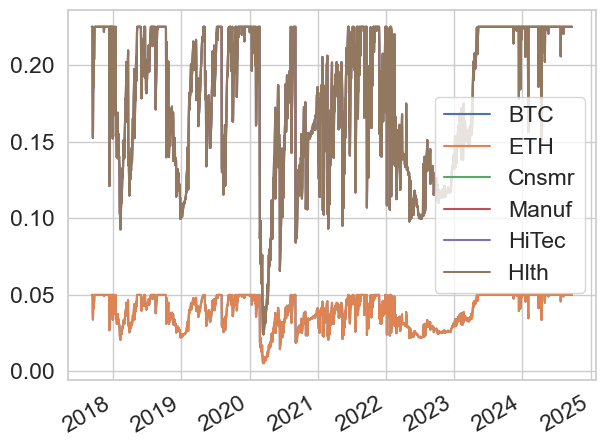

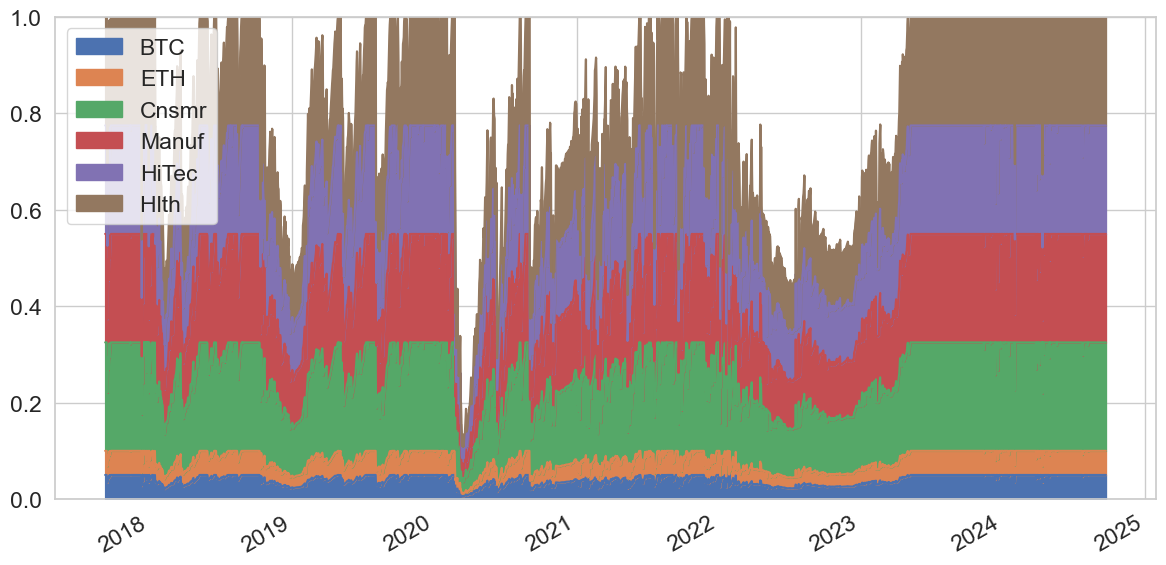

In [15]:
weights_ = weights_garch.loc[times]
weights_.plot()
plt.gcf().autofmt_xdate()
plt.tight_layout()


fig, ax = plt.subplots(figsize=(12, 6))
weights_.plot(kind='area', stacked=True, ax=ax, color=colors)
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/weights_garch.png')
plt.show()

In [16]:
# metrics_ewma.portfolio_returns.to_csv('cache/DD_ewma.csv') # NOTE: keep this
# metrics_garch.portfolio_returns.to_csv('cache/DD_garch.csv')